# 似た傾向のデータを活用して各項目の関係値をベイズ推論

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
import random

random.seed(42)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df_iris = sns.load_dataset('iris')  # アイリス・データセット
df_iris  # Data

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


`sepal_length` と `sepal_width` の回帰式を求める。    
$ Y_n = \alpha X_n + \beta + \epsilon_n $
- Y: sepal_width
- X: sepal_length
- alpha: 傾き
- beta: 切片
- epsilon: 誤差

In [3]:
# Sample の準備
df_setosa = df_iris.loc[df_iris['species'] == 'setosa']  # Setosa のみ
df_versicolor = df_iris.loc[df_iris['species'] == 'versicolor']  # Versicolor のみ
df_virginica = df_iris.loc[df_iris['species'] == 'virginica']  # Virginica のみ

# 乱数により 3-Index を生成
indexes = range(len(df_versicolor))  # 抽出する数字の配列を作成
indexes_sample = random.sample(indexes, 3)  # 3 Index 作成

# 各データから３つずつ Sample を抽出
df_setosa_select = df_setosa.iloc[indexes_sample]
df_versicolor_select = df_versicolor.iloc[indexes_sample]
df_virginica_select = df_virginica.iloc[indexes_sample]

# 抽出した各サンプルを結合
df_iris_select = pd.concat([df_setosa_select, df_versicolor_select, df_virginica_select], ignore_index=True)

df_iris_select

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.0,3.5,1.3,0.3,setosa
1,5.0,3.4,1.5,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,5.5,2.6,4.4,1.2,versicolor
4,4.9,2.4,3.3,1.0,versicolor
5,6.4,3.2,4.5,1.5,versicolor
6,6.7,3.1,5.6,2.4,virginica
7,7.3,2.9,6.3,1.8,virginica
8,5.8,2.7,5.1,1.9,virginica


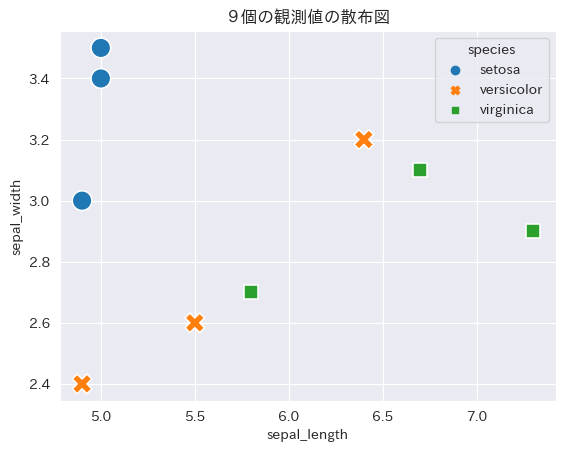

In [4]:
# 散布図
sns.scatterplot(data=df_iris_select, 
                x='sepal_length', 
                y='sepal_width', 
                hue='species', 
                style='species',
                s=200,
                )
plt.title('９個の観測値の散布図')
plt.show()

In [5]:
# ベイズ推論用に変数を作成
sepal_lengths   = df_iris_select['sepal_length'].values
sepal_widths    = df_iris_select['sepal_width'].values
species          = df_iris_select['species']
_species  = pd.Categorical(species).codes

print(sepal_lengths)
print(sepal_widths)
print(species)
print(_species)

[5.  5.  4.9 5.5 4.9 6.4 6.7 7.3 5.8]
[3.5 3.4 3.  2.6 2.4 3.2 3.1 2.9 2.7]
0        setosa
1        setosa
2        setosa
3    versicolor
4    versicolor
5    versicolor
6     virginica
7     virginica
8     virginica
Name: species, dtype: object
[0 0 0 1 1 1 2 2 2]


alpha と beta が品種によって異なるため、X, Y がどの品種に属するのか示す配列が `classes_species`

In [6]:
# 階層ベイズモデルの定義
model_hierarchical = pm.Model()

with model_hierarchical:
    X_sepal_length = pm.ConstantData('X_sepal_length', sepal_lengths) 
    Y_sepal_width  = pm.ConstantData('Y_sepal_width', sepal_widths)
    class_species  = pm.ConstantData('class_species', _species)  # クラス変数（階層ベイズ固有）
    
    # alpha:傾き（階層ベイズ固有）
    mu_a    = pm.Normal('mu_a', mu=0.0, sigma=10.0)
    sigma_a = pm.HalfNormal('sigma_a', sigma=10.0)
    alpha   = pm.Normal('alpha',
                        mu=mu_a,
                        sigma=sigma_a, 
                        shape=(3,))  # ３要素（個別に予測したい品種）の配列
    
    # beta:切片（階層ベイズ固有）
    mu_b    = pm.Normal('mu_b', mu=0.0, sigma=10.0)
    sigma_b = pm.HalfNormal('sigma_b', sigma=10.0)
    beta    = pm.Normal('beta', 
                        mu=mu_b,
                        sigma=sigma_b,
                        shape=(3,))  # ３要素（個別に予測したい品種）の配列
    
    # epsilon:誤差
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)
    
    # mu の値は、class_species により index を切り替えて計算
    mu = pm.Deterministic('mu', X_sepal_length * alpha[class_species] + beta[class_species])
    
    # 観測値
    observations = pm.Normal('observations', mu=mu, sigma=epsilon, observed=Y_sepal_width)

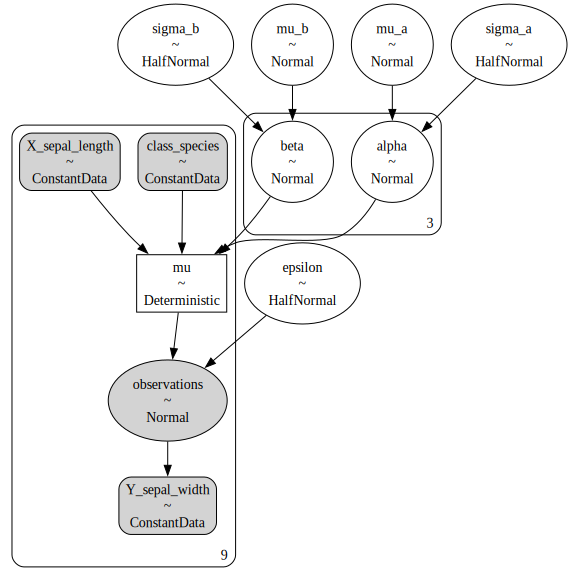

In [7]:
# 確率モデルの可視化
viz_model_hierarchical = pm.model_to_graphviz(model_hierarchical)
viz_model_hierarchical

In [9]:
# Sampling
with model_hierarchical:
    inference_hierarchical = pm.sample(random_seed=42, target_accept=0.998, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu_a, sigma_a, alpha, mu_b, sigma_b, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1173 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


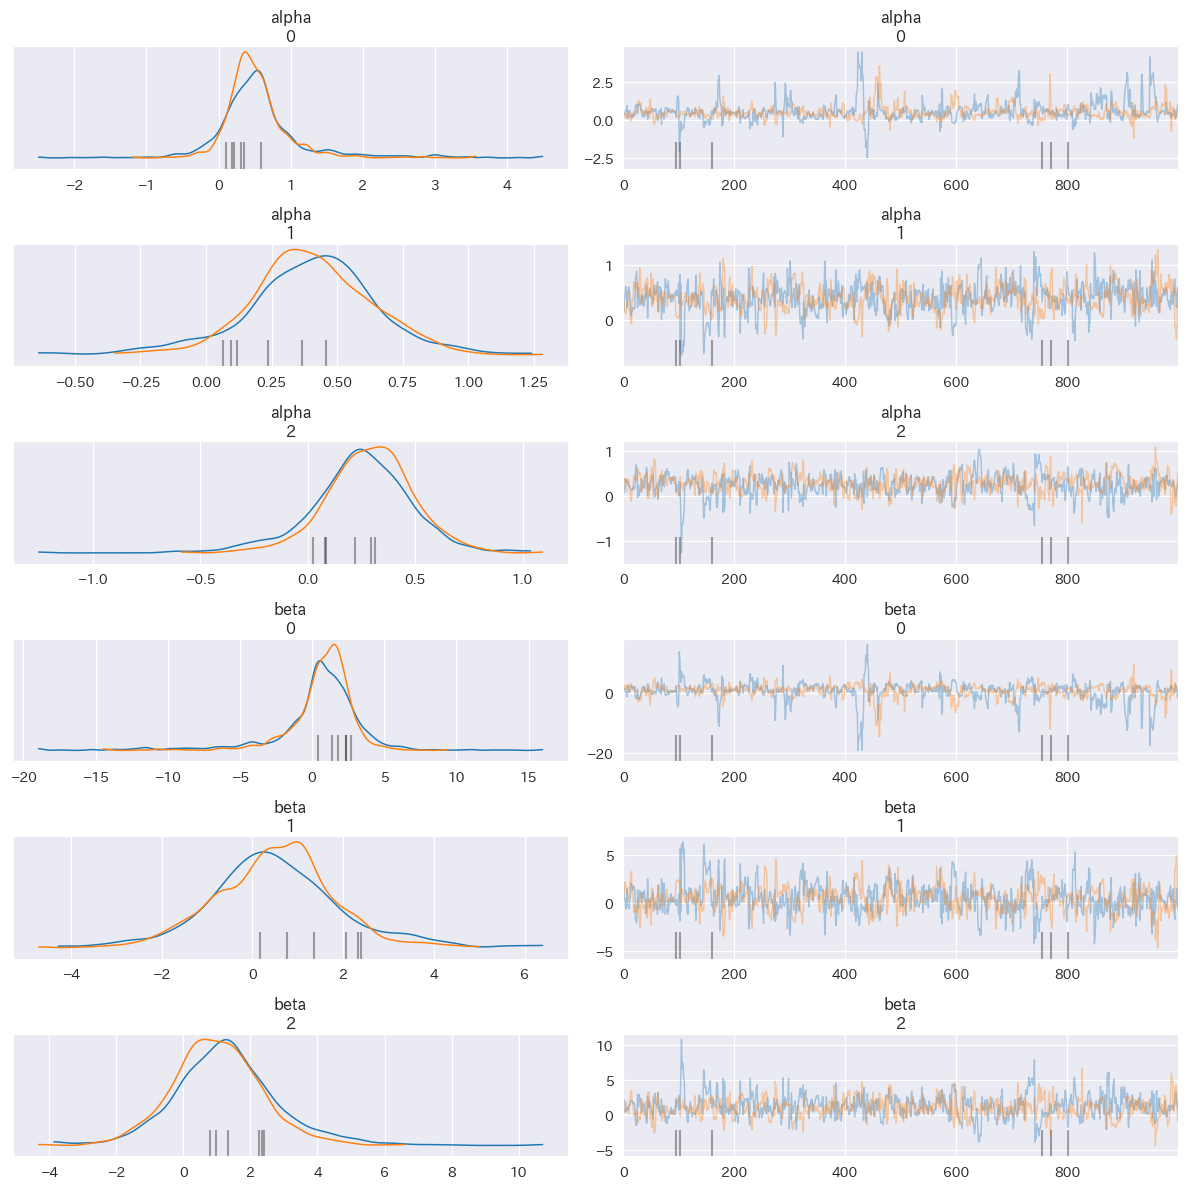

In [10]:
az.plot_trace(inference_hierarchical, compact=False, var_names=['alpha', 'beta'])
plt.tight_layout()
plt.show()

- 少し発散が生じている
- どの値も、２つのサンプル値系列で同じ波形をしている

推論結果としては、とりあえず問題なしと判断

In [13]:
# 統計分析
summary_hierarchical = az.summary(inference_hierarchical, var_names=['alpha', 'beta'])
summary_hierarchical

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.551,0.568,-0.360,1.592,0.034,0.026,292.0,301.0,1.01
alpha[1],0.400,0.247,-0.073,0.890,0.013,0.009,340.0,373.0,1.01
alpha[2],0.268,0.221,-0.195,0.654,0.011,0.008,389.0,435.0,1.01
beta[0],0.553,2.817,-4.541,5.149,0.170,0.135,291.0,297.0,1.01
beta[1],0.503,1.398,-1.947,3.576,0.075,0.053,341.0,382.0,1.00
beta[2],1.132,1.459,-1.917,3.662,0.074,0.054,391.0,418.0,1.01


- `r_hat` が1.01 以下 で推論はできている。
- `beta` に関して振れ幅が大きく、まだ十分な推論ができていない。

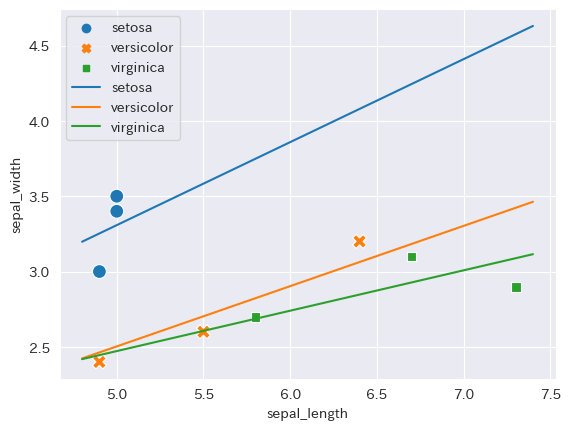

In [23]:
# 各確率変数の代表地（平均値）の回帰直接を描画

# alpha と beta の平均値
means = summary_hierarchical['mean']
alpha_0 = means['alpha[0]']
alpha_1 = means['alpha[1]']
alpha_2 = means['alpha[2]']
beta_0  = means['beta[0]']
beta_1  = means['beta[1]']
beta_2  = means['beta[2]']

# 回帰直線要座標値の計算
range_x = np.array([sepal_lengths.min()-0.1, sepal_lengths.max()+0.1])
range_y_0 = alpha_0 * range_x + beta_0
range_y_1 = alpha_1 * range_x + beta_1
range_y_2 = alpha_2 * range_x + beta_2

# 散布図
sns.scatterplot(data=df_iris_select, x='sepal_length', y='sepal_width', hue='species', style='species', s=100)
plt.plot(range_x, range_y_0, label='setosa')
plt.plot(range_x, range_y_1, label='versicolor')
plt.plot(range_x, range_y_2, label='virginica')
plt.legend()
plt.show()

`setosa` で抽出された３点は、近似直線の傾きで言うと、もっと大きな傾きになるはずなのが、他２つの回帰直線とほぼ同じ傾きになっているのは、階層ベイズモデルで推論をしているため。

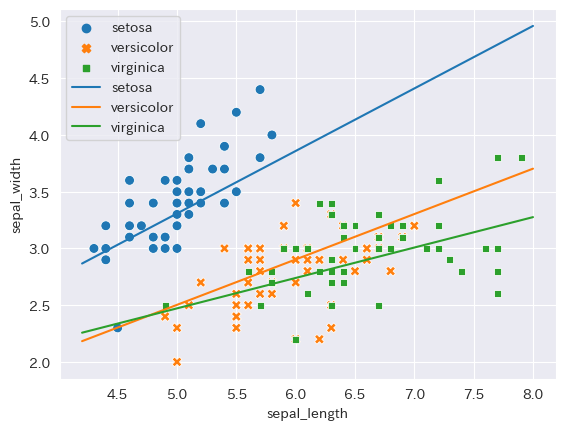

In [24]:
# 全体の散布図と回帰直線
# 回帰直線の座標値計算
range_x = np.array([
    df_iris['sepal_length'].min() - 0.1,
    df_iris['sepal_length'].max() + 0.1,
])
range_y_0 = alpha_0 * range_x + beta_0
range_y_1 = alpha_1 * range_x + beta_1
range_y_2 = alpha_2 * range_x + beta_2

# 散布図表示
sns.scatterplot(data=df_iris, x='sepal_length', y='sepal_width', hue='species', style='species', s=50)
plt.plot(range_x, range_y_0, label='setosa')
plt.plot(range_x, range_y_1, label='versicolor')
plt.plot(range_x, range_y_2, label='virginica')
plt.legend()
plt.show()

全体の散布図と比較して、階層ベイズモデルによる線形回帰の傾きの近似値は適切そう。